In [ ]:
# Install the required libraries
#Mobile SAM 
!git clone https://github.com/ChaoningZhang/MobileSAM.git

%pip install -e .

**Imports and Model Setup**

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from patchify import patchify
import random
import tifffile
from PIL import Image
import numpy as np
import glob

torch.cuda.is_available()

True

In [14]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

model_type = "vit_t"
sam_checkpoint = "mobile_sam.pt"
device = "cpu" # set device to cpu temporarily for dataset transforms

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)

predictor = SamPredictor(mobile_sam)
mask_generator = SamAutomaticMaskGenerator(mobile_sam)

**Generate Dataset**

In [2]:
# Load and stack color images
images = [np.array(Image.open(file)) for file in sorted(glob.glob("cloth_dataset/camera1_images/scene_*.png"))]
masks = [np.array(Image.open(file)) for file in sorted(glob.glob("cloth_dataset/binary_images/binary_*.png"))]

# Save as multi-page TIFF stacks with RGB for color images
tifffile.imwrite("cloth_dataset/cloth_images_stack.tif", np.array(images), photometric='rgb')
tifffile.imwrite("cloth_dataset/wrinkle_masks_stack.tif", np.array(masks), photometric='rgb')

In [15]:
#165 large images as tiff image stack
large_images_temp = tifffile.imread("cloth_dataset/cloth_images_stack.tif")
large_masks_temp = tifffile.imread("cloth_dataset/wrinkle_masks_stack.tif")

print(large_images_temp.shape) 
print(large_masks_temp.shape)

(1000, 546, 821, 4)
(1000, 546, 821, 4)


In [16]:
large_masks = large_masks_temp[..., 0]  # Take only the RGB channel
large_masks = large_masks.astype(np.uint8) 

large_images = large_images_temp[:, 34:546, 25:793, :3]
large_masks = large_masks[:, 34:546, 25:793]
print(large_images.shape) 
print(large_masks.shape)

(1000, 512, 768, 3)
(1000, 512, 768)


In [17]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    
    # Patchify with (patch_size, patch_size, 4) to include RGBA channels
    patches_img = patchify(large_image, (patch_size, patch_size, 3), step=step)

    # Iterate through the patches and append to all_img_patches
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, 0, :, :, :]  # Extract each patch with all channels
            all_img_patches.append(single_patch_img)

# Convert list of patches to numpy array
images = np.array(all_img_patches)

# Process masks, assuming they are single-channel (binary)
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]

    # If the mask has an extra channel dimension, reduce to single channel
    if large_mask.ndim == 3 and large_mask.shape[-1] == 4:
        large_mask = large_mask[:, :, 0]  # Take only one channel

    # Patchify for 2D patches on single-channel masks
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]  # Extract as 2D array
            single_patch_mask = (single_patch_mask / 255).astype(np.uint8)  # Normalize to binary if needed
            all_mask_patches.append(single_patch_mask)

# Convert list of patches to numpy array
masks = np.array(all_mask_patches)

# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)


Image shape: (4939, 256, 256, 3)
Mask shape: (4939, 256, 256)


In [18]:
import torch

#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = np.array([x_min, y_min, x_max, y_max])

  return bbox

# Add bounding boxes to the dataset
filtered_boxes = []
for mask in filtered_masks:
  filtered_boxes.append(get_bounding_box(mask))


In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

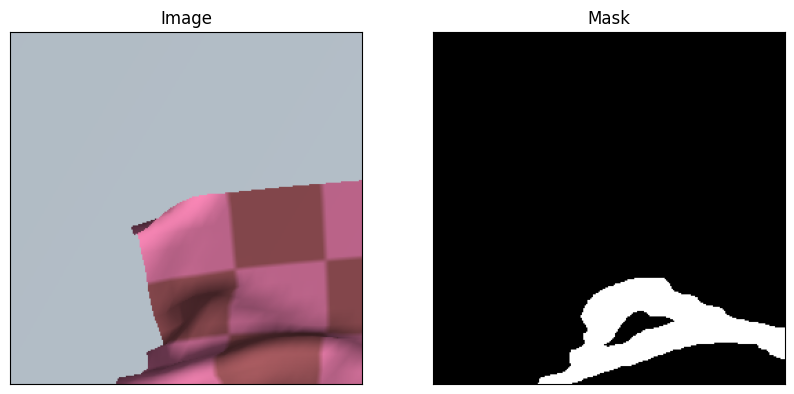

In [9]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image))  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

**Dataset Processor for MobileSAM**

In [30]:
import torch
from mobile_sam.utils import transforms

# Image transforms
transform = transforms.ResizeLongestSide(mobile_sam.image_encoder.img_size)

transformed_images = []
for img in filtered_images:
    transformed_image = torch.as_tensor(transform.apply_image(img), device="cpu")
    transformed_image = transformed_image.permute(2, 0, 1)
    transformed_images.append(transformed_image)

# Box transforms
transformed_boxes = []
for box in filtered_boxes:
    transformed_box = torch.as_tensor(transform.apply_boxes(box, (256, 256)), dtype=torch.float, device="cuda")[None, :]
    transformed_boxes.append(transformed_box)

# GT Mask transforms
transformed_masks = []
for mask in filtered_masks:
    transformed_mask = torch.from_numpy(mask).float()
    transformed_masks.append(transformed_mask)

In [54]:
batch = [
    [{
        "image": img,  # The image tensor
        "original_size": (256, 256),  # Original size of the image
        "boxes": boxes.requires_grad_().to("cuda"),  # Boxes for this image
        "ground_truth_mask": mask.to("cuda").requires_grad_()
    }]
    for img, boxes, mask in zip(transformed_images, transformed_boxes, transformed_masks)
]

In [9]:
# Save dataset
torch.save(batch, './cloth_dataset/batch.pt')
torch.save(filtered_images, './cloth_dataset/filtered_images.pt')
torch.save(filtered_masks, './cloth_dataset/filtered_masks.pt')
torch.save(filtered_boxes, './cloth_dataset/filtered_boxes.pt')

**Reset Model for Training**

In [2]:
batch = torch.load('./cloth_dataset/batch.pt')
#filtered_images = torch.load('./cloth_dataset/filtered_images.pt')
#filtered_masks = torch.load('./cloth_dataset/filtered_masks.pt')
#filtered_boxes = torch.load('./cloth_dataset/filtered_boxes.pt')

In [3]:
from mobile_sam import sam_model_registry, SamPredictor

model_type = "vit_t"
sam_checkpoint = "model/cloth_MobileSAM_checkpoint.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry["vit_t"](checkpoint="mobile_sam.pt")
mobile_sam.to(device=device)
predictor = SamPredictor(mobile_sam)

c:\Users\juhye\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\juhye\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
C:\Users\juhye\Desktop\Current Files\로봇비전\프로젝트\SAM_cloth_finetuning\MobileSAM\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
C:\Users\juhye

In [4]:
# Freeze layers in MobileSAM
for name, param in mobile_sam.named_parameters():
    if name.startswith("image_encoder"):  # Assuming "image_encoder" corresponds to the vision encoder
        param.requires_grad = False  # Freeze the vision encoder
    elif name.startswith("prompt_encoder"):  # Assuming "prompt_encoder" exists in MobileSAM
        param.requires_grad = False  # Freeze the prompt encoder

# Verify trainable parameters
trainable_params = sum(p.numel() for p in mobile_sam.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

# Iterate through all parameters and check their trainable status
print("MobileSAM Parameters:")
for name, param in mobile_sam.named_parameters():
        print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

# Count the total trainable parameters
trainable_params = sum(p.numel() for p in mobile_sam.parameters() if p.requires_grad)
print(f"\nTotal Trainable Parameters in MobileSAM: {trainable_params}")

Trainable parameters: 4058340
MobileSAM Parameters:
image_encoder.patch_embed.seq.0.c.weight: Frozen
image_encoder.patch_embed.seq.0.bn.weight: Frozen
image_encoder.patch_embed.seq.0.bn.bias: Frozen
image_encoder.patch_embed.seq.2.c.weight: Frozen
image_encoder.patch_embed.seq.2.bn.weight: Frozen
image_encoder.patch_embed.seq.2.bn.bias: Frozen
image_encoder.layers.0.blocks.0.conv1.c.weight: Frozen
image_encoder.layers.0.blocks.0.conv1.bn.weight: Frozen
image_encoder.layers.0.blocks.0.conv1.bn.bias: Frozen
image_encoder.layers.0.blocks.0.conv2.c.weight: Frozen
image_encoder.layers.0.blocks.0.conv2.bn.weight: Frozen
image_encoder.layers.0.blocks.0.conv2.bn.bias: Frozen
image_encoder.layers.0.blocks.0.conv3.c.weight: Frozen
image_encoder.layers.0.blocks.0.conv3.bn.weight: Frozen
image_encoder.layers.0.blocks.0.conv3.bn.bias: Frozen
image_encoder.layers.0.blocks.1.conv1.c.weight: Frozen
image_encoder.layers.0.blocks.1.conv1.bn.weight: Frozen
image_encoder.layers.0.blocks.1.conv1.bn.bias: F

**Training Loop**

In [5]:
from torch.optim import Adam
import monai

# Initialize the optimizer for the mask decoder
optimizer = Adam(mobile_sam.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# Define the segmentation loss function
# You can choose between DiceFocalLoss, FocalLoss, or DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [6]:
from tqdm import tqdm
from statistics import mean
import torch

# Training loop
num_epochs = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
mobile_sam.to(device)
mobile_sam.train()

for epoch in range(num_epochs):
    epoch_losses = []
    for i in tqdm(range(20)):  # Iterate through the dataset
        # Forward Pass
        single_batch = batch[i]
        single_batch[0]["image"] = single_batch[0]["image"].to(device)
        outputs = mobile_sam(batched_input = single_batch,
                             multimask_output = False)

        # Use the first (and only) predicted mask for training
        predicted_masks = outputs[0]["masks"].squeeze(1).float()
        ground_truth_masks = single_batch[0]["ground_truth_mask"].unsqueeze(0)
        loss = seg_loss(predicted_masks, ground_truth_masks)  # Add batch dimensions

        # Backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()
        # print(param)
        # print(loss.grad_fn(param))
    
        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


100%|██████████| 20/20 [00:02<00:00,  6.82it/s]


EPOCH: 0
Mean loss: 81.10007133483887


100%|██████████| 20/20 [00:01<00:00, 12.76it/s]


EPOCH: 1
Mean loss: 74.07870445251464


100%|██████████| 20/20 [00:01<00:00, 12.71it/s]

EPOCH: 2
Mean loss: 70.33458561897278


In [ ]:
# Save the state_dict after moving layers
torch.save(mobile_sam.state_dict(), "model/cloth_MobileSAM_checkpoint2.pth")

**Inference**

In [ ]:
from mobile_sam import sam_model_registry, SamPredictor

my_cloth_model = sam_model_registry["vit_t"](checkpoint="model/cloth_MobileSAM_checkpoint.pth")
my_cloth_model.eval()
predictor = SamPredictor(my_cloth_model)

In [18]:
idx = 0
predictor.set_image(np.transpose(filtered_images[idx], axes = (1, 2, 0)))
masks, _, _ = predictor.predict(box=filtered_boxes[idx], return_logits=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#axes[0].imshow(np.transpose(filtered_images[idx], axes = (1, 2, 0)))
#axes[0].set_title("Image")
axes[1].imshow(masks)
axes[1].set_title("Inference Output")

ValueError: pic should not have > 4 channels. Got 256 channels.

In [20]:
torch.cuda.empty_cache()